In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import pickle
import random

/home/haoran/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [35]:

# 有向无权图
# model_param = torch.load("./Joint_sahp/saved_models/sahp-synthetic_hidden16-20221224-202901.pth")
# 有向无权图带OT约束
# model_param = torch.load("./Joint_sahp/saved_models/sahp-synthetic_hidden16-20221224-203400.pth")
# 有向有权图
# model_param = torch.load("./Joint_sahp/saved_models/sahp-synthetic_hidden16-20221224-203524.pth")
# 有向有权图带OT约束
# model_param = torch.load("./Joint_sahp/saved_models/sahp-synthetic_hidden16-20221224-203943.pth")
# aligned_data = np.load("./data/ER_10_10/pairs_0.2_directed.npz")

# 无向无权图
# model_param = torch.load("./Joint_sahp/saved_models/sahp-synthetic_hidden16-20221224-201228.pth")
# 无向无权图带OT约束
# model_param = torch.load("./Joint_sahp/saved_models/sahp-synthetic_hidden16-20221224-202018.pth")
# 无向有权图
# model_param = torch.load("./Joint_sahp/saved_models/sahp-synthetic_hidden16-20221224-202503.pth")
# 无向有权图带OT约束
model_param = torch.load("./Joint_sahp/saved_models/sahp-synthetic_hidden16-20221224-202731.pth")
aligned_data = np.load("./data/ER_10_10/pairs_0.2_undirected.npz")

model_param.keys(), list(aligned_data)

(odict_keys(['type_emb_list.0.weight', 'type_emb_list.1.weight', 'position_emb.position', 'position_emb.div_term', 'position_emb.Wt.weight', 'attention.linear_layers.0.weight', 'attention.linear_layers.0.bias', 'attention.linear_layers.1.weight', 'attention.linear_layers.1.bias', 'attention.linear_layers.2.weight', 'attention.linear_layers.2.bias', 'attention.output_linear.weight', 'attention.output_linear.bias', 'feed_forward.w_1.weight', 'feed_forward.w_1.bias', 'feed_forward.w_2.weight', 'feed_forward.w_2.bias', 'input_sublayer.norm.a_2', 'input_sublayer.norm.b_2', 'output_sublayer.norm.a_2', 'output_sublayer.norm.b_2', 'start_layer.0.weight', 'start_layer.0.bias', 'converge_layer.0.weight', 'converge_layer.0.bias', 'decay_layer.0.weight', 'decay_layer.0.bias', 'intensity_layer_list.0.0.weight', 'intensity_layer_list.0.0.bias', 'intensity_layer_list.1.0.weight', 'intensity_layer_list.1.0.bias']),
 ['gnd_pairs', 'train_pairs', 'test_pairs'])

In [36]:
emb_0, emb_1 = model_param['type_emb_list.0.weight'][:-1].cpu(), model_param['type_emb_list.1.weight'][:-1].cpu()

/home/haoran/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/haoran/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


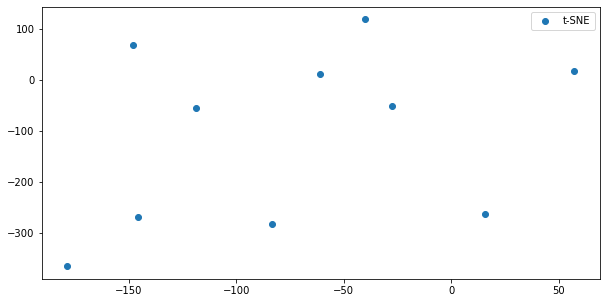

In [37]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, perplexity=3,random_state=33).fit_transform(emb_0)
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], label="t-SNE")
plt.legend()

/home/haoran/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/haoran/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


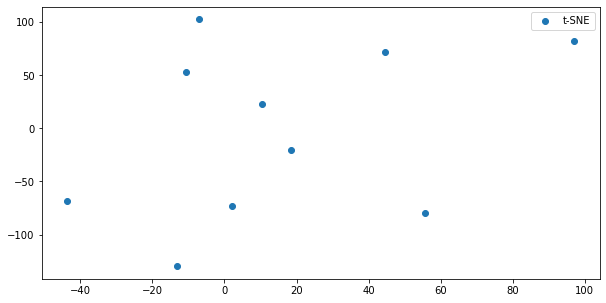

In [38]:
X_tsne = TSNE(n_components=2, perplexity=3,random_state=33).fit_transform(emb_1)
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], label="t-SNE")
plt.legend()

In [39]:
def sim_matrix(a, b, eps=1e-8):
    """
    added eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.clamp(a_n, min=eps)
    b_norm = b / torch.clamp(b_n, min=eps)
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt


def distance_tensor(pts_src: torch.Tensor, pts_dst: torch.Tensor, p: int = 2):
    """
    Returns the matrix of ||x_i-y_j||_p^p.
    :param pts_src: [R, D] matrix
    :param pts_dst: [C, D] matrix
    :param p:
    :return: [R, C, D] distance matrix
    """
    x_col = pts_src.unsqueeze(1)
    y_row = pts_dst.unsqueeze(0)
    distance = torch.abs(x_col - y_row) ** p
    return distance


def sinkhorn2(cost: torch.Tensor, tau: float, num: int, eps: float = 1e-6):
    x = -cost / tau
    for _ in range(num):
        x = x - torch.logsumexp(x, dim=1, keepdim=True)
        x = x - torch.logsumexp(x, dim=0, keepdim=True)
        if _ == 1:
            print('X: ', x)
    return torch.exp(x)

In [40]:
tau = 1e-3
num = 1000
cost_w = torch.sum(distance_tensor(emb_0, emb_1, p=2), dim=2)
print(cost_w)
trans_est = sinkhorn2(cost=cost_w, tau=tau, num=num)
print (trans_est.max(),
       trans_est.sum(),
      trans_est.sum(dim=1).max(), trans_est.sum(dim=1).min(),
      torch.diag(torch.flipud(trans_est)).max(), torch.diag(torch.flipud(trans_est)).min())

tensor([[1.8051, 2.9810, 2.5132, 3.6956, 0.7261, 2.9444, 3.0358, 2.2277, 1.9996,
         3.4157],
        [2.0122, 2.2015, 2.4283, 2.6603, 1.6440, 2.5473, 2.4969, 2.5805, 1.6625,
         3.5270],
        [2.0865, 4.6141, 2.6868, 3.7100, 4.0257, 3.7182, 2.4104, 3.7401, 2.4499,
         3.2010],
        [1.5640, 1.8840, 1.7065, 1.9464, 1.4809, 2.3670, 2.4645, 1.7667, 2.7489,
         3.7954],
        [1.2073, 2.2694, 1.7626, 2.6715, 1.6226, 1.7820, 3.3161, 2.1061, 1.5638,
         3.3142],
        [2.4522, 2.4680, 2.4741, 2.4789, 2.1266, 2.5183, 2.2074, 3.5348, 2.3699,
         1.8452],
        [2.3707, 2.3119, 2.2818, 2.6624, 1.2240, 1.7466, 3.1120, 0.9132, 2.0243,
         2.7379],
        [2.1019, 1.3231, 2.2627, 2.7974, 2.1898, 2.4452, 2.3499, 2.0366, 2.1635,
         2.5487],
        [2.2176, 2.0495, 1.9095, 1.5244, 2.4765, 2.5088, 3.2552, 3.2985, 2.2373,
         1.5776],
        [1.3648, 2.5740, 0.7085, 1.5360, 1.7037, 1.9469, 3.0491, 3.0932, 2.0651,
         3.1489]])
X:  tenso

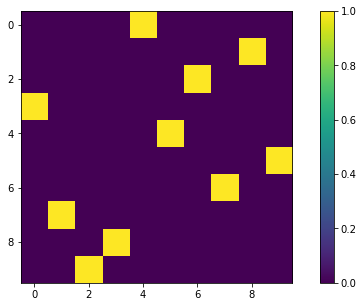

In [41]:
plt.figure(figsize=(10, 5))
plt.imshow(trans_est)
plt.colorbar()
# plt.savefig('Est.pdf')
# plt.close('all')

In [42]:
node_num0 = emb_0.shape[0]
node_num1 = emb_1.shape[0]
gnd_0 = torch.LongTensor(aligned_data['gnd_pairs'].astype(np.int32)[:, 0])
gnd_1 = torch.LongTensor(aligned_data['gnd_pairs'].astype(np.int32)[:, 1])
trans_real = torch.zeros((node_num0, node_num1))
for i, j in zip(gnd_0, gnd_1):
    trans_real[i, j] = 1.0
true_idx = torch.max(trans_real, dim=1).indices
predict_idx = torch.max(trans_est, dim=1).indices 
acc = (true_idx == predict_idx).sum()
true_idx, predict_idx, acc

(tensor([6, 4, 9, 1, 2, 5, 3, 0, 7, 8]),
 tensor([4, 8, 6, 0, 5, 9, 7, 1, 3, 2]),
 tensor(0))

In [43]:
trans_est_cosine = sim_matrix(emb_0, emb_1)
predict_idx_cosine = torch.max(trans_est_cosine, dim=1).indices
acc_cosine = (true_idx == predict_idx_cosine).sum()
true_idx, predict_idx_cosine, acc_cosine

(tensor([6, 4, 9, 1, 2, 5, 3, 0, 7, 8]),
 tensor([4, 8, 0, 7, 0, 9, 7, 1, 9, 2]),
 tensor(0))

In [44]:
trans_est_pdist1 = torch.cdist(emb_0, emb_1, p=1)
predict_idx_pdist1 = torch.max(trans_est_pdist1, dim=1).indices
acc_pdist1 = (true_idx == predict_idx_pdist1).sum()
true_idx, predict_idx_pdist1, acc_pdist1

(tensor([6, 4, 9, 1, 2, 5, 3, 0, 7, 8]),
 tensor([3, 9, 1, 9, 6, 7, 6, 3, 6, 6]),
 tensor(0))

In [45]:
trans_est_pdist2 = torch.cdist(emb_0, emb_1, p=2)
predict_idx_pdist2 = torch.max(trans_est_pdist2, dim=1).indices
acc_pdist2 = (true_idx == predict_idx_pdist2).sum()
true_idx, predict_idx_pdist2, acc_pdist2

(tensor([6, 4, 9, 1, 2, 5, 3, 0, 7, 8]),
 tensor([3, 9, 1, 9, 6, 7, 6, 3, 7, 9]),
 tensor(1))

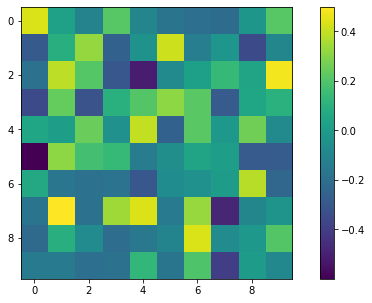

In [27]:
plt.figure(figsize=(10, 5))
plt.imshow(trans_est_cosine)
plt.colorbar()

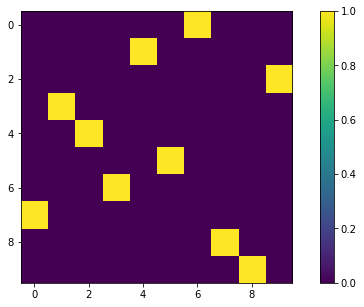

In [15]:
plt.figure(figsize=(10, 5))
plt.imshow(trans_real)
plt.colorbar()

In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
m = Categorical(torch.tensor([ 0,0, 0.25, 0.25 ]))

a=torch.tensor([1,2,3])

a[:-1]

tensor([1, 2])

In [2]:
for i in range(10):
    print(m.sample())

tensor(3)
tensor(2)
tensor(3)
tensor(2)
tensor(3)
tensor(3)
tensor(2)
tensor(3)
tensor(3)
tensor(3)


In [3]:
import numpy as np

a=np.array([
    [
        [1,2,3],
        [4,9,6]
    ],
     [
        [1,2,3],
        [4,5,6]
    ],
     [
        [1,2,3],
        [4,5,6]
    ]
])

np.max(a,axis=1)

array([[4, 9, 6],
       [4, 5, 6],
       [4, 5, 6]])

In [8]:
embedding = nn.Embedding(3, 3)
a=torch.tensor([
    [0,1,0],
    [1,0,0],
    [0,0,1]
])
e= nn.Embedding(5, 6, padding_idx=1)

e.weight,e(torch.tensor(1))

(Parameter containing:
 tensor([[-0.9972,  1.6495, -1.6660,  1.0666, -0.1427,  2.5630],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.5499,  1.1843, -0.2520, -0.6407,  0.0912,  1.9714],
         [ 2.0574,  1.7108, -0.7763,  1.7504, -0.2578, -0.6238],
         [ 0.4631,  0.4221, -0.9828, -0.8251,  1.8313,  0.4824]],
        requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0.], grad_fn=<EmbeddingBackward0>))

In [18]:
x=1-e(torch.tensor(1))*3

In [19]:
l=x.mean()
l.backward()

In [20]:
print(e.weight.data)

tensor([[-0.9972,  1.6495, -1.6660,  1.0666, -0.1427,  2.5630],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5499,  1.1843, -0.2520, -0.6407,  0.0912,  1.9714],
        [ 2.0574,  1.7108, -0.7763,  1.7504, -0.2578, -0.6238],
        [ 0.4631,  0.4221, -0.9828, -0.8251,  1.8313,  0.4824]])


In [3]:
import numpy as np
a = np.array([[1,2,3],[2,3,4],[1,6,5], [9,3,4]])
a[:,[1,0,2]]

array([[2, 1, 3],
       [3, 2, 4],
       [6, 1, 5],
       [3, 9, 4]])

In [32]:
d=dict(a.reshape(b.shape))
import numpy as np

In [36]:
np.array(list(d.items()))

array([[1, 2],
       [3, 4]], dtype=int64)